<a href="https://colab.research.google.com/github/undertow515/123123/blob/main/idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.read_csv(r"https://raw.githubusercontent.com/undertow515/123123/refs/heads/main/ks_1972_current_hourly_prcp_asos.csv", parse_dates=["datetime"], index_col="datetime")
df2 = pd.read_csv(r"https://raw.githubusercontent.com/undertow515/123123/refs/heads/main/ks_2000_2024_hourly_prcp_aws.csv", parse_dates=["datetime"], index_col="datetime")
df3 = pd.read_csv(r"https://raw.githubusercontent.com/undertow515/123123/refs/heads/main/ks_2025_hourly_prcp_aws.csv", parse_dates=["datetime"], index_col="datetime")
df = pd.concat([df2, df3])

# df.fillna(0, inplace=True)

# df["precip_mm"].describe()

<Axes: >

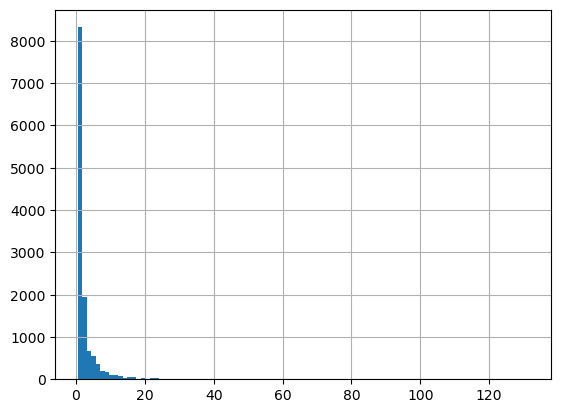

In [ ]:
df[df["precip_intensity"] > 0]["precip_intensity"].hist(bins=100)

# IDF Curve Analysis (Intensity-Duration-Frequency)

## What are IDF Curves?
IDF curves show the relationship between:
- **Intensity**: Average rainfall rate (mm/hr)
- **Duration**: Time period (1hr, 2hr, 3hr, etc.)
- **Frequency**: Return period or probability of occurrence

## Methodology
1. **Data Preparation**: Roll up hourly precipitation data into different durations
2. **Distribution Fitting**: Fit three probability distributions to each duration:
   - **Gamma Distribution**: Good for modeling skewed positive data
   - **Log-Normal Distribution**: Good for data that's log-normally distributed
   - **Log-Pearson Type 3**: Widely used in hydrology, especially for extreme events
3. **Parameter Estimation**: Use Method of Moments to estimate distribution parameters
4. **Curve Generation**: Calculate intensities for different return periods


Gamma params: (0.2962415924061792, 0, 1.8792326516632076)
Lognormal params: (1.2149275539923674, 0, 0.2661378375291684)

Distribution: gamma
Parameters: (0.2962415924061792, 0, 1.8792326516632076)
Data mean: 0.557, Data std: 1.023


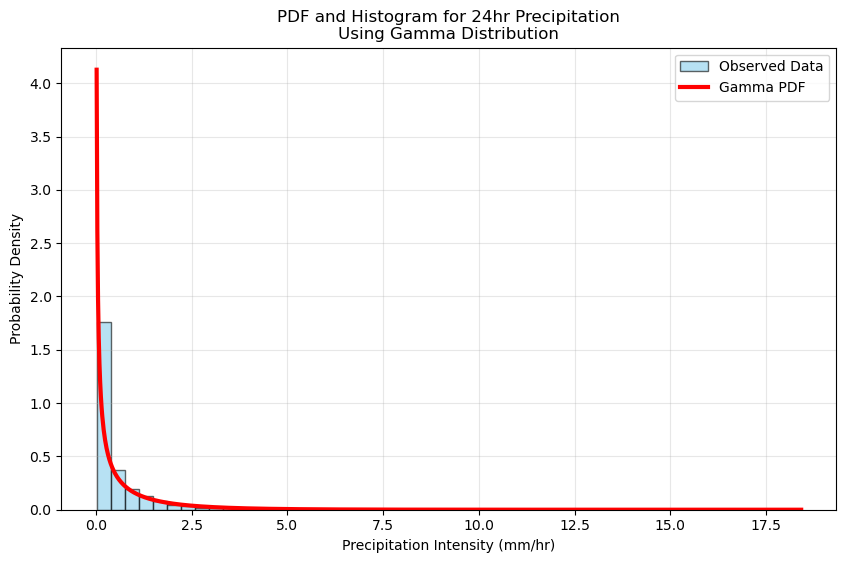

In [ ]:
# let's draw idf curves`!

# we use 3 types of distributions: gamma, lognormal, logpearsontype3

# first, we need to roll up the data into different durations (1hr, 2hr, 3hr, 6hr, 9hr, 12hr, 24hr)

durations = [1, 2, 3, 6, 9, 12, 24]  # in hours

for duration in durations:
    df[f"precip_{duration}hr"] = df["precip_intensity"].rolling(window=duration).mean() # intensity is the average over the duration mm / hr (i d f : intensity - duration - frequency)


dist_dict = {
    "gamma": stats.gamma,
    "lognormal": stats.lognorm,
    "logpearson3": stats.pearson3
}

# but! we would fit this manually

# gamma distribution : shape, loc(fixed), scale

# to estimate the parameters, we can use the method of moments

# which is to equate the sample moments to the theoretical moments

# shape = (mean / std) ** 2

# scale = std ** 2 / mean


def fit_gamma(data):
    mean = np.mean(data)
    std = np.std(data)
    shape = (mean / std) ** 2
    scale = std ** 2 / mean
    return shape, 0, scale

# lognormal distribution : shape, loc, scale

# to estimate the parameters, we can use the method of moments

# shape (sigma) = sqrt(ln(1 + (std / mean) ** 2))

# location = 0 (fixed)

# scale (mu) = ln(mean) - 0.5 * shape ** 2

def fit_lognormal(data):
    mean = np.mean(data)
    std = np.std(data)
    shape = np.sqrt(np.log(1 + (std / mean) ** 2))
    scale = np.exp(np.log(mean) - 0.5 * shape ** 2)
    return shape, 0, scale


# logpearson3 distribution : shape, loc, scale

# to estimate the parameters, we can use the method of moments


# shape = skewness coefficient
# loc = mean - shape * std
# scale = std


data_sample = df[df["precip_24hr"] > 0]["precip_24hr"].values
gamma_params = fit_gamma(data_sample)
lognormal_params = fit_lognormal(data_sample)

print("Gamma params:", gamma_params)
print("Lognormal params:", lognormal_params)


def plot_pdf_and_hist(df, duration, dist_name, dist_params):
    data = df[df[f"precip_{duration}hr"] > 0][f"precip_{duration}hr"].values

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, density=True, alpha=0.6, color='skyblue',
             label='Observed Data', edgecolor='black')

    # Plot PDF
    x = np.linspace(min(data), max(data), 1000)
    dist = dist_dict[dist_name]
    pdf = dist.pdf(x, *dist_params)

    plt.plot(x, pdf, 'r-', lw=3, label=f'{dist_name.capitalize()} PDF')

    plt.title(f'PDF and Histogram for {duration}hr Precipitation\nUsing {dist_name.capitalize()} Distribution')
    plt.xlabel('Precipitation Intensity (mm/hr)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Print some statistics for debugging
    print(f"\nDistribution: {dist_name}")
    print(f"Parameters: {dist_params}")
    print(f"Data mean: {np.mean(data):.3f}, Data std: {np.std(data):.3f}")
    if dist_name == "logpearson3":
        print(f"Log data mean: {np.mean(np.log(data)):.3f}, Log data std: {np.std(np.log(data)):.3f}")
        print(f"Log data skewness: {stats.skew(np.log(data)):.3f}")

    plt.show()

plot_pdf_and_hist(df, 24, "gamma", gamma_params)




## Probability Distributions Explained

### 1. Gamma Distribution
- **Use case**: Good for modeling positive, skewed data like precipitation
- **Parameters**:
  - Shape (α) = (mean/std)²
  - Scale (β) = std²/mean
  - Location = 0 (fixed)
- **Characteristics**: Flexible shape, always positive values

### 2. Log-Normal Distribution  
- **Use case**: When the logarithm of the data follows a normal distribution
- **Parameters**:
  - Shape (σ) = √[ln(1 + (std/mean)²)]
  - Scale (μ) = exp[ln(mean) - 0.5×σ²]
  - Location = 0 (fixed)
- **Characteristics**: Right-skewed, good for multiplicative processes

### 3. Log-Pearson Type 3 Distribution
- **Use case**: Widely used in hydrology for extreme precipitation analysis
- **Parameters**:
  - Shape = skewness coefficient of log-transformed data
  - Location = mean_log - shape × std_log  
  - Scale = std_log
- **Characteristics**: Very flexible, can handle various skewness levels

![image.png](attachment:image.png)

### Method of Moments
We use the **Method of Moments** to estimate parameters by equating:
- Sample moments (mean, variance, skewness)
- Theoretical moments of the distribution

This is simpler than Maximum Likelihood Estimation but still provides good estimates for IDF analysis.

In [ ]:
# Generate IDF curves for different return periods
return_periods = [2, 5, 10, 25, 50, 100]  # years
probabilities = [1 - 1/rp for rp in return_periods]  # exceedance probabilities

# Dictionary to store results
idf_results = {}

# For each distribution
for dist_name in ["gamma", "lognormal", "logpearson3"]:
    idf_results[dist_name] = {}

    # For each duration
    for duration in durations:
        col_name = f"precip_{duration}hr"

        # Get non-zero precipitation data for this duration
        data = df[df[col_name] > 0.5][col_name].dropna()
        ldata = np.log(data[data > 0])

        if len(data) < 10:  # Need sufficient data
            continue

        # Fit the appropriate distribution
        if dist_name == "gamma":
            params = fit_gamma(data)
            dist = stats.gamma
        elif dist_name == "lognormal":
            params = fit_lognormal(data)
            dist = stats.lognorm
        elif dist_name == "logpearson3":
            params = stats.pearson3.fit(ldata)
            # For log-Pearson type 3, we need to work with log-transformed data
            dist = stats.pearson3

        # Calculate intensities for each return period
        intensities = []
        for prob in probabilities:
            if dist_name == "logpearson3":
                # For log-Pearson type 3, calculate on log scale then transform back
                log_intensity = dist.ppf(prob, params[0], loc=params[1], scale=params[2])
                intensity = np.exp(log_intensity)

            else:
                intensity = dist.ppf(prob, params[0], loc=params[1], scale=params[2])
            intensities.append(intensity)

        idf_results[dist_name][duration] = intensities

print("IDF curve calculation completed!")
print(f"Calculated for {len(durations)} durations and {len(return_periods)} return periods")
print(f"Using distributions: {list(idf_results.keys())}")

IDF curve calculation completed!
Calculated for 7 durations and 6 return periods
Using distributions: ['gamma', 'lognormal', 'logpearson3']


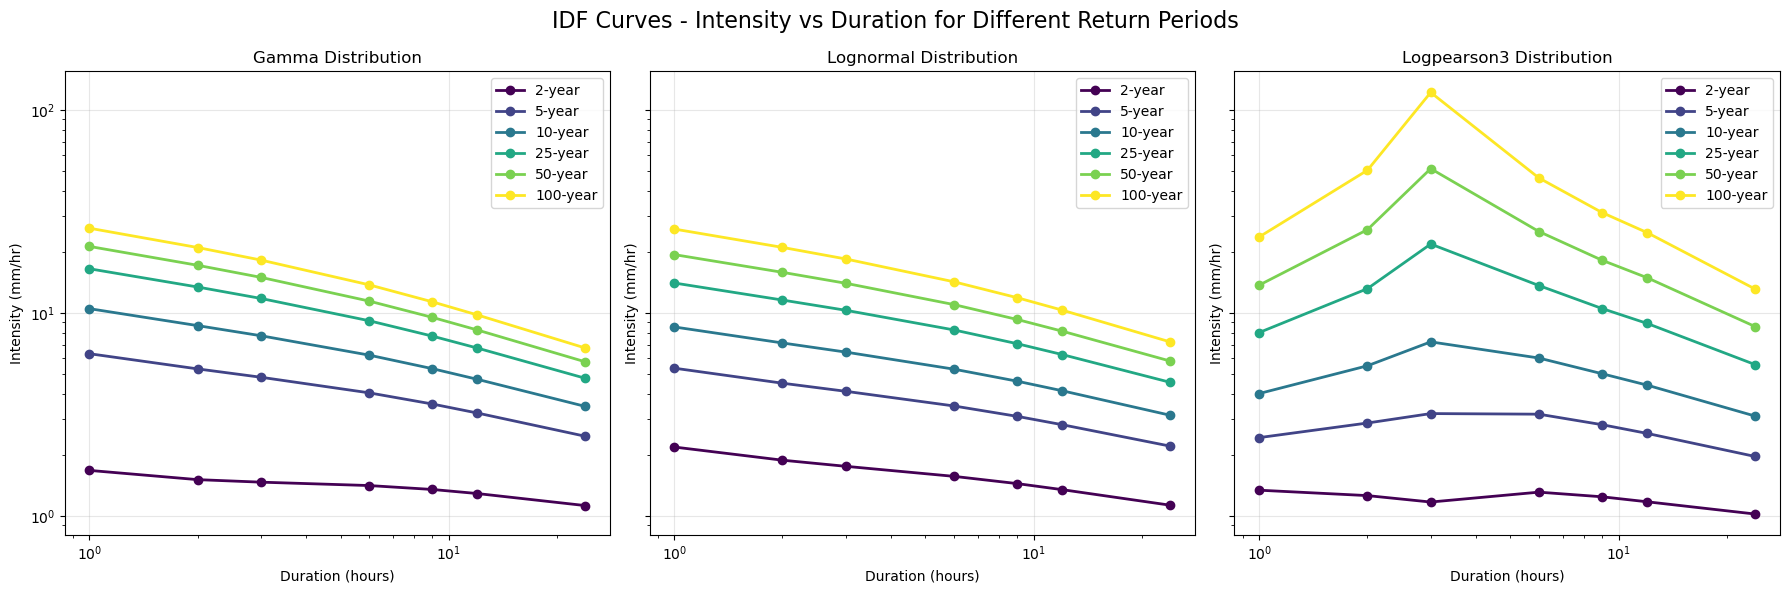


Sample IDF values (Gamma distribution):
Duration (hr) | 2-year | 10-year | 100-year
---------------------------------------------
          1 |   1.68 |    10.52 |     26.21
          2 |   1.51 |     8.68 |     21.05
          3 |   1.47 |     7.74 |     18.26
          6 |   1.41 |     6.21 |     13.79
          9 |   1.35 |     5.33 |     11.37
         12 |   1.29 |     4.72 |      9.80
         24 |   1.13 |     3.47 |      6.73


In [ ]:
# Plot IDF curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('IDF Curves - Intensity vs Duration for Different Return Periods', fontsize=16)

colors = plt.cm.viridis(np.linspace(0, 1, len(return_periods)))

for i, (dist_name, ax) in enumerate(zip(["gamma", "lognormal", "logpearson3"], axes)):
    ax.set_title(f'{dist_name.capitalize()} Distribution')

    # Plot each return period
    for j, rp in enumerate(return_periods):
        intensities = []
        valid_durations = []

        for duration in durations:
            if duration in idf_results[dist_name]:
                intensities.append(idf_results[dist_name][duration][j])
                valid_durations.append(duration)

        if intensities:  # Only plot if we have data
            ax.loglog(valid_durations, intensities, 'o-',
                     color=colors[j], label=f'{rp}-year', linewidth=2, markersize=6)

    ax.set_xlabel('Duration (hours)')
    ax.set_ylabel('Intensity (mm/hr)')
    ax.grid(True, alpha=0.3)
    ax.legend()



plt.tight_layout()
plt.show()

# Print some sample values
print("\nSample IDF values (Gamma distribution):")
print("Duration (hr) | 2-year | 10-year | 100-year")
print("-" * 45)
for duration in durations:
    if duration in idf_results["gamma"]:
        values = idf_results["gamma"][duration]
        print(f"{duration:11} | {values[0]:6.2f} | {values[2]:8.2f} | {values[5]:9.2f}")

In [ ]:
df["precip_1hr"].max(), df["precip_1hr"].idxmax()

(131.5, Timestamp('2012-08-13 02:00:00'))

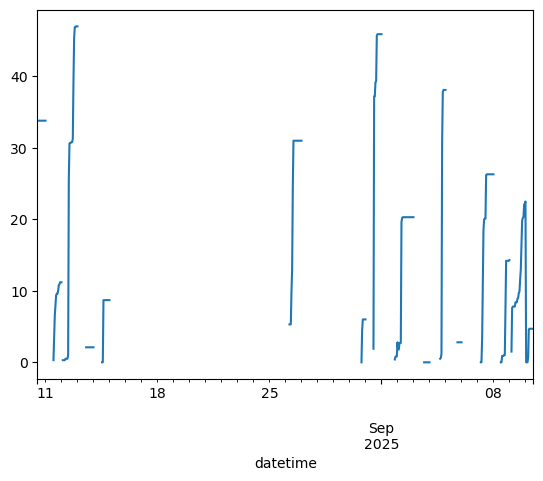

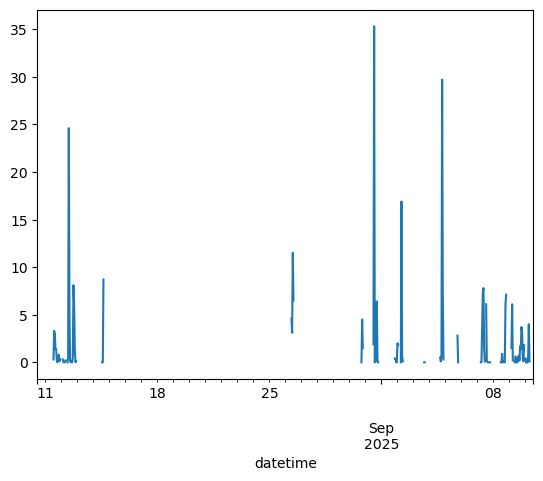

In [ ]:
df3 = pd.read_csv(r"https://raw.githubusercontent.com/undertow515/123123/refs/heads/main/ks_1972_current_hourly_prcp_asos.csv", parse_dates=["datetime"], index_col="datetime")
# df3["precip_intensity"].max(), df3["precip_intensity"].idxmax()
df3["2025-07-20 15:00":]["precip_intensity"].plot();plt.show();df3["2025-07-20 15:00":]["precip_mm"].plot();plt.show();


Returns
-------
res: KstestResult
    An object containing attributes:
    
    statistic : float
        KS test statistic, either D+, D-, or D (the maximum of the two)
    pvalue : float
        One-tailed or two-tailed p-value.
    statistic_location : float
        In a one-sample test, this is the value of `rvs`
        corresponding with the KS statistic; i.e., the distance between
        the empirical distribution function and the hypothesized cumulative
        distribution function is measured at this observation.
    
        In a two-sample test, this is the value from `rvs` or `cdf`
        corresponding with the KS statistic; i.e., the distance between
        the empirical distribution functions is measured at this
        observation.
    statistic_sign : int
        In a one-sample test, this is +1 if the KS statistic is the
        maximum positive difference between the empirical distribution
        function and the hypothesized cumulative distribution function
        (D+); it is -1 if the KS statistic is the maximum negative
        difference (D-).
    
        In a two-sample test, this is +1 if the empirical distribution
        function of `rvs` exceeds the empirical distribution
        function of `cdf` at `statistic_location`, otherwise -1.

In [ ]:
# lastly, let's do the gof tests with ks-1tail test
r= {}
for dist_name in ["gamma", "lognormal", "logpearson3", "weibull_min", "gev", "gumbel_r"]:
    for duration in durations:
        col_name = f"precip_{duration}hr"

        # Get non-zero precipitation data for this duration
        data = df[df[col_name] > 0.5][col_name].dropna()

        if len(data) < 10:  # Need sufficient data
            continue

        # Fit the appropriate distribution
        if dist_name == "gamma":
            params = stats.gamma.fit(data, floc=0)
            dist = stats.gamma
        elif dist_name == "lognormal":
            params = stats.lognorm.fit(data, floc=0)
            dist = stats.lognorm
        elif dist_name == "logpearson3":
            ldata = np.log(data[data > 0])
            params = stats.pearson3.fit(ldata)
            dist = stats.pearson3
        elif dist_name == "weibull_min":
            params = stats.weibull_min.fit(data, floc=0)
            dist = stats.weibull_min
        elif dist_name == "gev":
            params = stats.genextreme.fit(data)
            dist = stats.genextreme

        # Perform KS test
        try:
            if dist_name == "logpearson3":
                ks_stat, p_value = stats.kstest(np.log(data), dist_name, args=params)
            else:
                ks_stat, p_value = stats.kstest(data, dist_name, args=params)
        except Exception as e:
            if dist_name == "lognormal":
                ks_stat, p_value = stats.kstest(data, "lognorm", args=params)
            # ks_stats, p_value = np.nan, np.nan
        r[(dist_name, duration)] = (ks_stat, p_value)

        print(f"KS test for {dist_name} distribution on {duration}hr data: KS stat={ks_stat:.4f}, p-value={p_value:.4f}")

KS test for gamma distribution on 1hr data: KS stat=0.1800, p-value=0.0000
KS test for gamma distribution on 2hr data: KS stat=0.1566, p-value=0.0000
KS test for gamma distribution on 3hr data: KS stat=0.1447, p-value=0.0000
KS test for gamma distribution on 6hr data: KS stat=0.1295, p-value=0.0000
KS test for gamma distribution on 9hr data: KS stat=0.1250, p-value=0.0000
KS test for gamma distribution on 12hr data: KS stat=0.1241, p-value=0.0000
KS test for gamma distribution on 24hr data: KS stat=0.1261, p-value=0.0000
KS test for lognormal distribution on 1hr data: KS stat=0.1482, p-value=0.0000
KS test for lognormal distribution on 2hr data: KS stat=0.1162, p-value=0.0000
KS test for lognormal distribution on 3hr data: KS stat=0.1034, p-value=0.0000
KS test for lognormal distribution on 6hr data: KS stat=0.0884, p-value=0.0000
KS test for lognormal distribution on 9hr data: KS stat=0.0855, p-value=0.0000
KS test for lognormal distribution on 12hr data: KS stat=0.0851, p-value=0.000

### The lower ks statistics -> ??

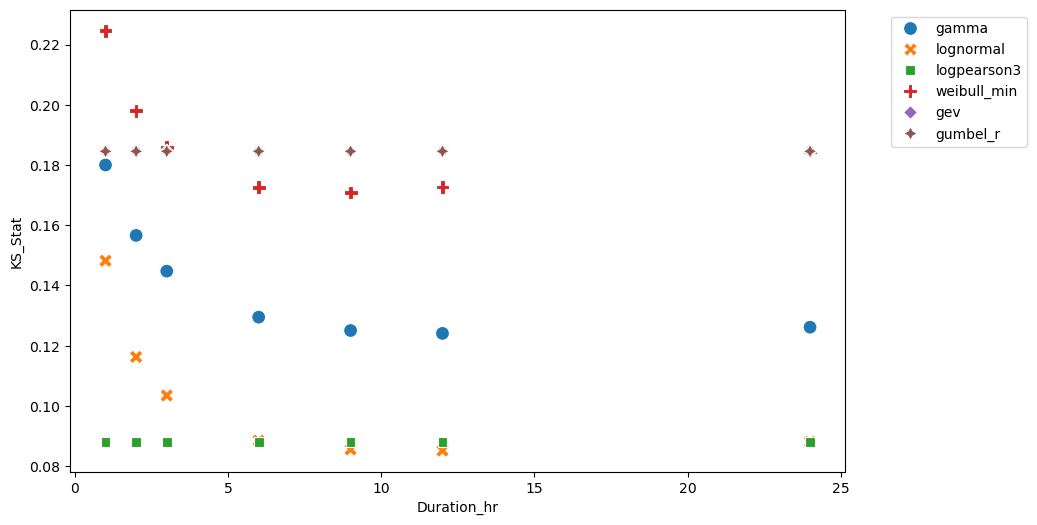

In [ ]:
results_df = pd.DataFrame.from_dict(r, orient='index', columns=['KS_Stat', 'P_Value'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Distribution', 'Duration_hr'])
results_df.reset_index(inplace=True)
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Duration_hr', y='KS_Stat', hue='Distribution', style='Distribution', s=100,)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# plot the pdf and histogram again for dists
ldata = np.log(data[data > 0.5])
params = stats.pearson3.fit(ldata)

# rp = 100
lv = stats.pearson3.ppf(0.995, params[0], loc=params[1], scale=params[2])
value = np.exp(lv)
value * 24


480.2121709269919